In [1]:
import tensorflow as tf
import numpy as np
import gym
from go_ai import data, metrics, policies
from go_ai.models import value_model, actor_critic
import matplotlib.pyplot as plt
import shutil
import multiprocessing as mp
import os

# Hyperparameters

In [2]:
BOARD_SIZE = 4

In [3]:
ITERATIONS = 256
EPISODES_PER_ITERATION = 128
NUM_EVAL_GAMES = 128

In [4]:
INIT_TEMP = 1/64
TEMP_DECAY = 0.9
MIN_TEMP = 1/64

In [5]:
BATCH_SIZE = 32

In [6]:
LOAD_SAVED_MODELS = True

# Data Parameters

In [7]:
NUM_WORKERS = 4 #mp.cpu_count() - 1
print("Workers: ", NUM_WORKERS)

Workers:  4


In [8]:
EPISODES_DIR = './data/'

In [9]:
MODELS_DIR = 'models/'
CHECKPOINT_PATH = MODELS_DIR + 'checkpoint_{}x{}.h5'.format(BOARD_SIZE, BOARD_SIZE)
TMP_MODEL_PATH = MODELS_DIR + 'tmp.h5'
TMP_MCTS_PATH = MODELS_DIR + 'tmp_mcts.h5'

In [10]:
DEMO_TRAJECTORY_PATH = 'logs/a_trajectory.png'

# Go Environment
Train on a small board for fast training and efficient debugging

In [11]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE)

# Preview Model

In [12]:
if LOAD_SAVED_MODELS:
    assert os.path.exists(CHECKPOINT_PATH)
    print("Starting from checkpoint")
else:
    val_net = value_model.make_model(BOARD_SIZE)
    val_net.save(CHECKPOINT_PATH)
    print("Initialized checkpoint and temp") 
print()
    
# Sync temp with checkpoint
shutil.copy(CHECKPOINT_PATH, TMP_MODEL_PATH)

model = tf.keras.models.load_model(TMP_MODEL_PATH)
model.summary()

Starting from checkpoint

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               24832     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
re_lu_1 (ReLU)               (

In [13]:
actor_critic = actor_critic.make_model(BOARD_SIZE)
actor_critic.save(TMP_MCTS_PATH)

# Policies

In [14]:
tmp_policy_args = policies.PolicyArgs('qtemp', BOARD_SIZE, TMP_MODEL_PATH, name='tmp', 
                                      temperature=INIT_TEMP)
checkpoint_policy_args = policies.PolicyArgs('qtemp', BOARD_SIZE, CHECKPOINT_PATH, name='checkpoint', 
                                             temperature=INIT_TEMP)
random_policy_args = policies.PolicyArgs('random', BOARD_SIZE)
greedy_policy_args = policies.PolicyArgs('greedy', BOARD_SIZE)
human_policy_args = policies.PolicyArgs('human', BOARD_SIZE)
mcts_policy_args = policies.PolicyArgs('monte_carlo', BOARD_SIZE, TMP_MCTS_PATH, max_searches=50)

# Demo and Time Games

Symmetries

In [14]:
%%time
go_env.reset()
action = (1, 1)
next_state, _, _, _ = go_env.step(action)
metrics.plot_symmetries(next_state, 'logs/symmetries.jpg')

CPU times: user 240 ms, sys: 11 ms, total: 251 ms
Wall time: 258 ms


With replay memory

In [15]:
%%time
data.make_episodes(tmp_policy_args, tmp_policy_args, 1, num_workers=1, 
                   outdir=EPISODES_DIR)

Episode worker: 1it [00:00,  2.57it/s]
tmp vs. tmp: 100%|██████████| 1/1 [00:00<00:00, 1095.40it/s, 0.0% WIN]

CPU times: user 1.81 s, sys: 41 ms, total: 1.85 s
Wall time: 1.85 s


0.0

In [16]:
%%time
fig = metrics.gen_traj_fig(go_env, tmp_policy_args)
fig.savefig(DEMO_TRAJECTORY_PATH)
plt.close()

CPU times: user 6.06 s, sys: 187 ms, total: 6.25 s
Wall time: 5.66 s


CPU times: user 10.6 s, sys: 671 ms, total: 11.3 s
Wall time: 9.64 s


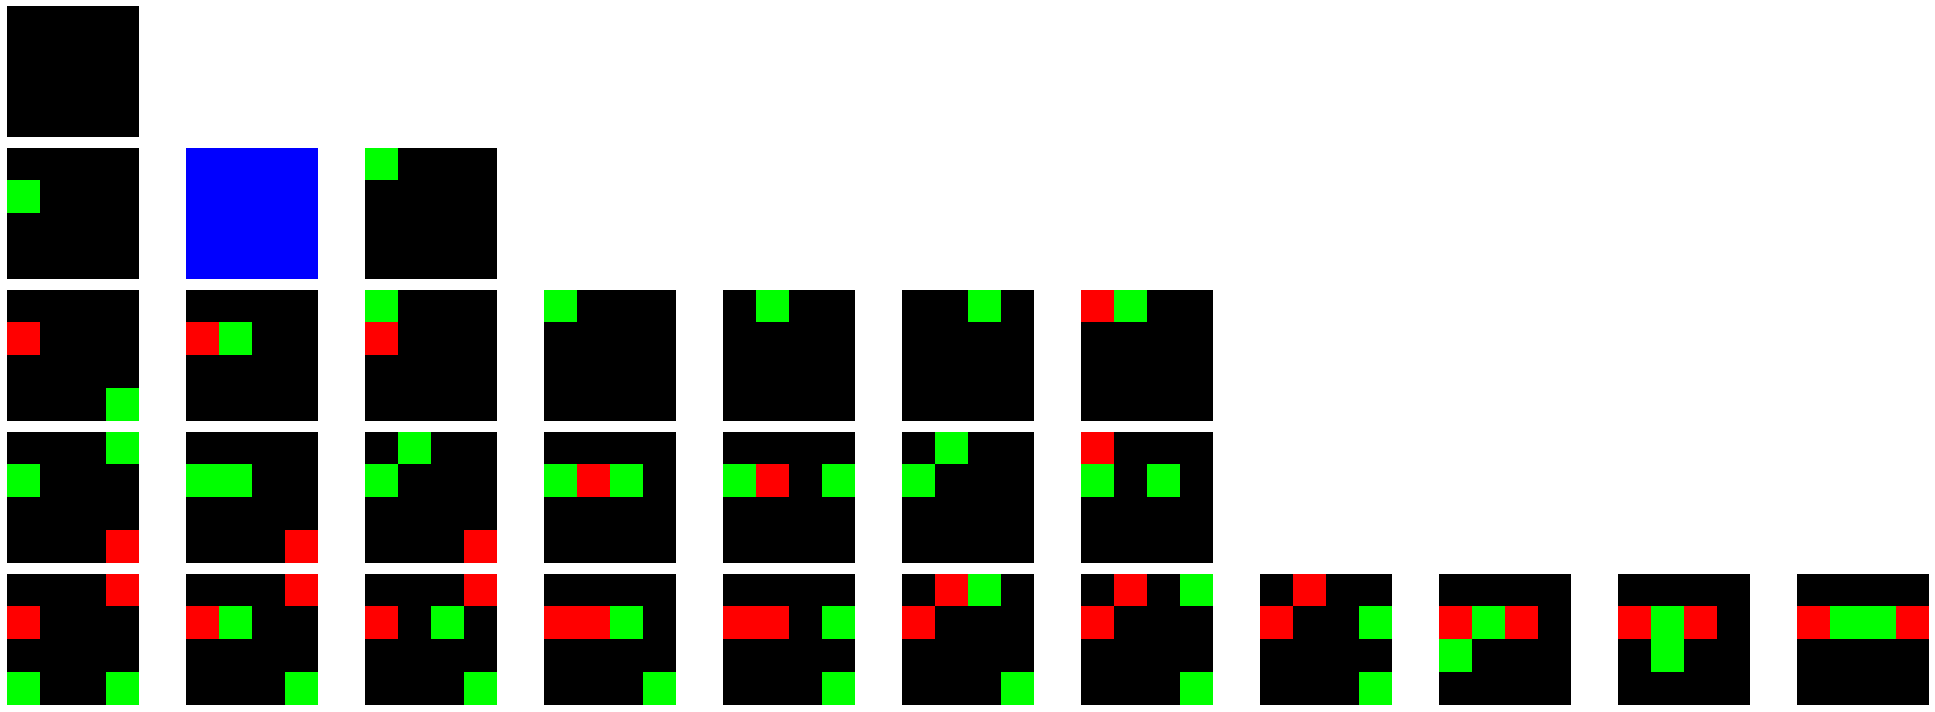

In [15]:
%%time
fig = metrics.gen_mct_plot(go_env, mcts_policy_args, max_layers=5, max_branch=3)

# Train

In [17]:
def decay_temps(policy_args_list, temp_decay, min_temp):
    for policy_args in policy_args_list:
        assert hasattr(policy_args, 'temperature')
        policy_args.temperature *= temp_decay
        if policy_args.temperature < min_temp:
            policy_args.temperature = min_temp
        print(f"{policy_args.name} temperature decayed to {policy_args.temperature}")

In [18]:
def set_temps(policy_args_list, temp):
    for policy_args in policy_args_list:
        assert hasattr(policy_args, 'temperature')
        policy_args.temperature = temp
        print(f"{policy_args.name} temperature set to {policy_args.temperature}")

In [19]:
for iteration in range(ITERATIONS):
    print(f"Iteration {iteration}")
    
    # Make and write out the episode data
    data.make_episodes(tmp_policy_args, tmp_policy_args, EPISODES_PER_ITERATION, 
                       num_workers=NUM_WORKERS, outdir=EPISODES_DIR)
    # Read in the episode data
    replay_data = data.episodes_from_dir(EPISODES_DIR)

    # Optimize
    value_model.optimize(tmp_policy_args, replay_data, BATCH_SIZE)
    
    # Evaluate against checkpoint model and other baselines
    opp_win_rate = data.make_episodes(tmp_policy_args, checkpoint_policy_args, 
                                      NUM_EVAL_GAMES, NUM_WORKERS)

    if opp_win_rate > 0.6:
        # New parameters are significantly better. Accept it
        shutil.copy(TMP_MODEL_PATH, CHECKPOINT_PATH)
        print(f"{100*opp_win_rate:.1f}% Accepted new model")
        
        rand_win_rate = data.make_episodes(tmp_policy_args, random_policy_args, 
                                           NUM_EVAL_GAMES, NUM_WORKERS)
        greed_win_rate = data.make_episodes(tmp_policy_args, greedy_policy_args, 
                                            NUM_EVAL_GAMES, NUM_WORKERS)
        print(f"{100*greed_win_rate:.1f}%G {100*rand_win_rate:.1f}%R")

        # Plot samples of states and response heatmaps
        fig = metrics.gen_traj_fig(go_env, tmp_policy_args)
        fig.savefig(DEMO_TRAJECTORY_PATH)
        plt.close()
    elif opp_win_rate >= 0.4:
        # New parameters are significantly worse. Reject it.
        print(f"{100*opp_win_rate:.1f}% Continuing to train current weights")
    else:
        # Keep trying
        shutil.copy(CHECKPOINT_PATH, TMP_MODEL_PATH)
        print(f"{100*opp_win_rate:.1f}% Rejected new model")
        
    # Decay the temperatures if any
    decay_temps([tmp_policy_args, checkpoint_policy_args], TEMP_DECAY, MIN_TEMP)

Iteration 0


tmp vs. tmp: 100%|██████████| 128/128 [00:17<00:00,  7.35it/s, 59.0% WIN]


Train on 3471 samples
3471/3471 [==============================] - 1s 272us/sample - loss: 0.6198 - binary_accuracy: 0.6194


tmp vs. checkpoint: 100%|██████████| 128/128 [00:17<00:00,  7.20it/s, 46.5% WIN]


46.5% Continuing to train current weights
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 1


tmp vs. tmp: 100%|██████████| 128/128 [00:15<00:00,  8.28it/s, 52.3% WIN]


Train on 2810 samples
2810/2810 [==============================] - 1s 310us/sample - loss: 0.4172 - binary_accuracy: 0.8238


tmp vs. checkpoint: 100%|██████████| 128/128 [00:18<00:00,  7.03it/s, 56.2% WIN]


56.2% Continuing to train current weights
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 2


tmp vs. tmp: 100%|██████████| 128/128 [00:17<00:00,  7.39it/s, 49.2% WIN]


Train on 3544 samples
3544/3544 [==============================] - 1s 269us/sample - loss: 0.6513 - binary_accuracy: 0.6185


tmp vs. checkpoint: 100%|██████████| 128/128 [00:17<00:00,  7.33it/s, 51.6% WIN]


51.6% Continuing to train current weights
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 3


tmp vs. tmp: 100%|██████████| 128/128 [00:14<00:00,  9.09it/s, 57.8% WIN]


Train on 2517 samples
2517/2517 [==============================] - 1s 468us/sample - loss: 0.4480 - binary_accuracy: 0.7986


tmp vs. checkpoint: 100%|██████████| 128/128 [00:18<00:00,  7.08it/s, 61.7% WIN]


61.7% Accepted new model


tmp vs. greedy: 100%|██████████| 128/128 [00:14<00:00,  8.67it/s, 80.1% WIN]


80.1%G 99.2%R
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 4


tmp vs. tmp: 100%|██████████| 128/128 [00:16<00:00,  7.96it/s, 47.7% WIN]


Train on 3233 samples
3233/3233 [==============================] - 1s 282us/sample - loss: 0.4486 - binary_accuracy: 0.7358


tmp vs. checkpoint: 100%|██████████| 128/128 [00:17<00:00,  7.42it/s, 24.2% WIN]


24.2% Rejected new model
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 5


tmp vs. tmp: 100%|██████████| 128/128 [00:16<00:00,  7.78it/s, 45.3% WIN]


Train on 3385 samples
3385/3385 [==============================] - 1s 274us/sample - loss: 0.4335 - binary_accuracy: 0.7427


tmp vs. checkpoint: 100%|██████████| 128/128 [00:16<00:00,  7.70it/s, 21.1% WIN]


21.1% Rejected new model
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 6


tmp vs. tmp: 100%|██████████| 128/128 [00:16<00:00,  7.78it/s, 46.1% WIN]


Train on 3388 samples
3388/3388 [==============================] - 1s 274us/sample - loss: 0.4344 - binary_accuracy: 0.7397


tmp vs. checkpoint: 100%|██████████| 128/128 [00:16<00:00,  7.72it/s, 14.1% WIN]


14.1% Rejected new model
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 7


tmp vs. tmp: 100%|██████████| 128/128 [00:16<00:00,  7.58it/s, 56.2% WIN]


Train on 3386 samples
3386/3386 [==============================] - 1s 275us/sample - loss: 0.4974 - binary_accuracy: 0.6834


tmp vs. checkpoint: 100%|██████████| 128/128 [00:16<00:00,  7.62it/s, 24.2% WIN]


24.2% Rejected new model
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 8


tmp vs. tmp: 100%|██████████| 128/128 [00:16<00:00,  7.80it/s, 53.1% WIN]


Train on 3349 samples
3349/3349 [==============================] - 1s 277us/sample - loss: 0.4997 - binary_accuracy: 0.7053


tmp vs. checkpoint: 100%|██████████| 128/128 [00:16<00:00,  7.85it/s, 18.0% WIN]


18.0% Rejected new model
tmp temperature decayed to 0.015625
checkpoint temperature decayed to 0.015625
Iteration 9


tmp vs. tmp: 100%|██████████| 128/128 [00:16<00:00,  7.58it/s, 53.1% WIN]


Train on 3428 samples
3428/3428 [==============================] - 1s 274us/sample - loss: 0.4937 - binary_accuracy: 0.7039


tmp vs. checkpoint: 100%|██████████| 128/128 [00:18<00:00,  6.85it/s, 18.8% WIN]


KeyboardInterrupt: 

# Evaluate

Play against our AI

In [ ]:
set_temps([tmp_policy_args, checkpoint_policy_args], 0)

In [ ]:
data.make_episodes(greedy_policy_args, checkpoint_policy_args, 256)

In [ ]:
data.make_episodes(checkpoint_policy_args, human_policy_args, 1)